# FHIR for Research Workshop - Exercise 3

## Drug on Drug Interactions

 For this exercise we will explore potential drug on drug interactions in a sizable patient cohort stored in a FHIR format, by drawing drug interaction data from the NIH's Drug RxNAV database that includes open APIs we can reference against our patient population. 
 
 The goal of this exercise is to effectively map data formatted in different standards such that the information contained in one resource (the Drug API), can be harnessed to provide richer insights into our patient population.


## Scenario: Potential Drug on Drug Interaction Risks in a Patient Population
To complete this exercise we will pull information on prescriptions from our patient cohort, and then leveraging the NIH Drug on Drug API we will determine which patients have the potential risk of an adverse event due to a drug interaction. 

For this initial analysis we will want to do the following:
### Key Activities:
<ol>
    <li> Query all active prescriptions in our patient cohort</li>
    <li> Determine how to query the API and then construct a mechanism to feed our patient info into that API to determine if a known Drug on Drug Interaction could occur.</li>
    <li> Construct a composite list of all drugs per-patient (so we can determine a potential Drug on Drug interaction)</li>
    <li> Construct a program to loop through our entire patient cohort and for each patient determine the presence of a known risk.</li>

### Motivation/Purpose
From a research persective we can envision leveraging these sorts of analyses to do post-market surveilance of drugs to determine both the rate of known adverse events among patients, as well as to potentially flag additional risks not yet identified. 

From a clinical perspective, this exercise demonstrates the power of a SMART of FHIR application, where third-party data (in this case Drug on Drug interaction data), can be pulled in, paired with FHIR formatted clinical data, and then leveraged to better inform patient care in the form of Clinical Decision Support tools. 

### Key Skills Practiced
For this scenario, the key challenge will be in mapping the API query to our data and constructing a data structure capable of leveraging it automatically. 

## Step 1: Query all active prescriptions in our patient cohort

For this exercise we will call on the 'MedicationRequest' resource which is the closest equivalent to a prescriptions resource in FHIR. 

Each item in this resource is effectively a single prescription, such that you may have a many-to-one relationship of prescriptions to patients.

(This fact will be critical for our exercise, as determining a potential drug on drug interaction will require effectively grouping medication request resources by patient, to determine if the patient is on multiple concurrent prescriptions. We will therefore want to make sure we can include the relevant patient information to ensure we can map multiple prescritpions to individual patients.)

In [1]:
# Here's a set of libraries we'll import for this exercise
import requests
import json
import pandas as pd
from pandas import json_normalize

### Compose the proper query

First compose a query to pull the 'MedicationRequest' resource from your client server. Then convert it to json format. Optionally, you can output the resulting JSON file to confirm that you've successfully queried the database.

In [2]:
r = requests.get(f"https://api.logicahealth.org/researchonfhir/open/MedicationRequest?", verify=False)
bundle = r.json()
r

/opt/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


<Response [200]>

We can now leverage the methods we deployed previously in Exercises 1 and 2 to map and ultimately convert our JSON into a dataframe. 

As a first step let's leverage the list mapping lambda function we deployed in Exercise 1 to map out our JSON file (entering the entire bundle, and mapping by resource) 

As a unit test let's return the first resource item (index 0 or [0]) so we can get a better look at what information we have to work with.

In [3]:
prescriptions = list(map(lambda e: e['resource'], bundle['entry']))
prescriptions[0]

{'resourceType': 'MedicationRequest',
 'id': 'smart-MedicationRequest-101',
 'meta': {'versionId': '1',
  'lastUpdated': '2020-07-15T02:51:25.000+00:00',
  'source': '#KQSArAdbxORTtqVw'},
 'text': {'status': 'generated',
  'div': '<div xmlns="http://www.w3.org/1999/xhtml">Nizatidine 15 MG/ML Oral Solution [Axid] (rxnorm: 582620)</div>'},
 'status': 'active',
 'intent': 'order',
 'medicationCodeableConcept': {'coding': [{'system': 'http://www.nlm.nih.gov/research/umls/rxnorm',
    'code': '582620',
    'display': 'Nizatidine 15 MG/ML Oral Solution [Axid]'}],
  'text': 'Nizatidine 15 MG/ML Oral Solution [Axid]'},
 'subject': {'reference': 'Patient/smart-1032702'},
 'dosageInstruction': [{'text': '10 mL bid',
   'timing': {'repeat': {'boundsPeriod': {'start': '2008-04-05'},
     'frequency': 2,
     'period': 1,
     'periodUnit': 'd'}}}],
 'dispenseRequest': {'numberOfRepeatsAllowed': 1,
  'quantity': {'value': 1.0,
   'unit': 'mL',
   'system': 'http://unitsofmeasure.org',
   'code': 'm

### Mount Data onto a Pandas Dataframe

Now that we've confirmed that we've extracted information we need from our client server, we will then take the FHIR formatted data and convert it into a pandas dataframe for subsequent analysis.

Based on our previous exercises we know we can use the JSON_normalize function parse the JSON into a pandas dataframe. Let's do that now and then output the resulting dataframe to confirm we've successfully converted it.

In [4]:
dfprescriptions = pd.json_normalize(prescriptions)
dfprescriptions.head()

,resourceType,id,status,intent,dosageInstruction,meta.versionId,meta.lastUpdated,meta.source,text.status,text.div,...,subject.reference,dispenseRequest.numberOfRepeatsAllowed,dispenseRequest.quantity.value,dispenseRequest.quantity.unit,dispenseRequest.quantity.system,dispenseRequest.quantity.code,dispenseRequest.expectedSupplyDuration.value,dispenseRequest.expectedSupplyDuration.unit,dispenseRequest.expectedSupplyDuration.system,dispenseRequest.expectedSupplyDuration.code
0,MedicationRequest,smart-MedicationRequest-101,active,order,"[{'text': '10 mL bid', 'timing': {'repeat': {'...",1,2020-07-15T02:51:25.000+00:00,#KQSArAdbxORTtqVw,generated,"<div xmlns=""http://www.w3.org/1999/xhtml"">Niza...",...,Patient/smart-1032702,1,1.0,mL,http://unitsofmeasure.org,mL,30,days,http://unitsofmeasure.org,d
1,MedicationRequest,smart-MedicationRequest-102,active,order,"[{'text': '7 mL bid x 10 days', 'timing': {'re...",1,2020-07-15T02:51:26.000+00:00,#WnCTEkK79sEBIQNe,generated,"<div xmlns=""http://www.w3.org/1999/xhtml"">Amox...",...,Patient/smart-1081332,1,1.0,mL,http://unitsofmeasure.org,mL,10,days,http://unitsofmeasure.org,d
2,MedicationRequest,smart-MedicationRequest-103,active,order,"[{'text': '5 mL bid x 10 days', 'timing': {'re...",1,2020-07-15T02:51:26.000+00:00,#WnCTEkK79sEBIQNe,generated,"<div xmlns=""http://www.w3.org/1999/xhtml"">Amox...",...,Patient/smart-1081332,1,1.0,mL,http://unitsofmeasure.org,mL,10,days,http://unitsofmeasure.org,d
3,MedicationRequest,smart-MedicationRequest-104,active,order,"[{'text': '15 mL daily x 3 days', 'timing': {'...",1,2020-07-15T02:51:26.000+00:00,#WnCTEkK79sEBIQNe,generated,"<div xmlns=""http://www.w3.org/1999/xhtml"">Azit...",...,Patient/smart-1081332,1,1.0,mL,http://unitsofmeasure.org,mL,3,days,http://unitsofmeasure.org,d
4,MedicationRequest,smart-MedicationRequest-105,active,order,"[{'text': '7 mL bid x 10 days', 'timing': {'re...",1,2020-07-15T02:51:26.000+00:00,#WnCTEkK79sEBIQNe,generated,"<div xmlns=""http://www.w3.org/1999/xhtml"">cefd...",...,Patient/smart-1081332,1,1.0,mL,http://unitsofmeasure.org,mL,10,days,http://unitsofmeasure.org,d


Depending on how you've parsed it, certain fields are immediately usable in their current form. For others, we're going to need to do further work to parse out the precise information we want to work with. 

While we will pause our work on the dataframe for the moment, it may be worth pausing to document our current set of available features and their potential utility.

So we now have a basic datafame with drug and patient information. Before we can begin trying to construct a parser, we need to examine our API to see how data is submitted and returned.

## Step 2: Determine how to query the API and then construct a mechanism to feed our patient info into that API to determine if a known Drug on Drug Interaction could occur.

Reviewing the NIH's RX Norm database documentation. Link here: https://lhncbc.nlm.nih.gov/RxNav/APIs/index.html

We see one clear option we have to use is the RX CUI code using the six-digit NDC code
https://lhncbc.nlm.nih.gov/RxNav/APIs/api-RxNorm.getNDCs.html

This correllates with our Patient data column: resource.medicationCodeableConcept.codingcodes (quite a mouthful!, but we'll deal with that shortly).

Let's pull two sample interactions using the following general notation:

URL/list.json?rxcuis=[code 1]+[code 2]


 - The URL is: https://rxnav.nlm.nih.gov/REST/interaction/

Two combinations we can try are:
 - 207106 and 656659
 - 762675 and 859258

Convert the response to both into JSON format and output it to see what sort of information the API returns

In [5]:
url = 'https://rxnav.nlm.nih.gov/REST/interaction/list.json?rxcuis=207106+656659'
response = (requests.get(url).text)
response_json = json.loads(response)
response_json

{'nlmDisclaimer': 'It is not the intention of NLM to provide specific medical advice, but rather to provide users with information to better understand their health and their medications. NLM urges you to consult with a qualified physician for advice about medications.',
 'fullInteractionTypeGroup': [{'sourceDisclaimer': 'DrugBank is intended for educational and scientific research purposes only and you expressly acknowledge and agree that use of DrugBank is at your sole risk. The accuracy of DrugBank information is not guaranteed and reliance on DrugBank shall be at your sole risk. DrugBank is not intended as a substitute for professional medical advice, diagnosis or treatment..[www.drugbank.ca]',
   'sourceName': 'DrugBank',
   'fullInteractionType': [{'comment': 'Drug1 (rxcui = 207106, name = fluconazole 50 MG Oral Tablet [Diflucan], tty = SBD). Drug2 (rxcui = 656659, name = bosentan 125 MG Oral Tablet, tty = SCD). Drug1 is resolved to fluconazole, Drug2 is resolved to bosentan and 

In [6]:
url = 'https://rxnav.nlm.nih.gov/REST/interaction/list.json?rxcuis=762675+859258'
response = (requests.get(url).text)
response_json = json.loads(response)
response_json

{'nlmDisclaimer': 'It is not the intention of NLM to provide specific medical advice, but rather to provide users with information to better understand their health and their medications. NLM urges you to consult with a qualified physician for advice about medications.'}

Feel free to experiment with additional drug combinations, including 3 or more drugs to see how the information varies.

Taking stock, we have successfully accessed the API, and hopefully now have an understanding of how the API returns when there is a Drug interaction versus when there isn't.

We now have important information informing our next steps. 

Firstly we have a structured target to work toward for submitting our patient data to this API. For each patient, we will need to compile a list of RXCUI codes to the prescriptions they are on, and then append them to our API query with a '+' between each code. For our next step we'll go about constructing that!

The second bit of information we have is an understanding of how the API returns a known interaction, versus how it returns when there isn't one. We can begin to consider how the format of this data can be used to indicate-in bulk-the presence or absence of a reaction.

## Step 3: Construct a composite list of all drugs per-patient (so we can determine a potential Drug on Drug interaction

So now we know that in order to engage our RXNorm server we need to extract and submit our patient's six digit RXCUI code, let's go back to our original mappedJSON file and try to do a list comprehension to extract the specific code.

Then wrapping that within a Series function and executing a to_frame() method on the resulting series, we can create a dataframe with our desired RXCode. Try it now. Output the result to confirm you've successfully extracted the desired information and converted it properly.

In [7]:
rxcodes = pd.Series([codings['code'] for MedicationRequest in prescriptions for codings in MedicationRequest['medicationCodeableConcept']['coding']], name='rxcode')

dfcode = rxcodes.to_frame()

In [8]:
dfcode.head()

,rxcode
0,582620
1,308189
2,617993
3,211307
4,261091


Let's now consolidate our dataframe to retain the information we need. Specifically we'll need information identifying the patient,an indication on whether or not the prescription is active or not (as only active prescriptions could cause a drug interaction, and finally the RXCode we previously extracted. 

Construct your final dataframe and then output the result to confirm you've retained the desired information.

In [9]:
dffinal = dfprescriptions[['subject.reference', 'status']]
dffinal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subject.reference  50 non-null     object
 1   status             50 non-null     object
dtypes: object(2)
memory usage: 928.0+ bytes


In [10]:
dffinal['rxcode'] = dfcode['rxcode']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
dffinal.head()

,subject.reference,status,rxcode
0,Patient/smart-1032702,active,582620
1,Patient/smart-1081332,active,308189
2,Patient/smart-1081332,active,617993
3,Patient/smart-1081332,active,211307
4,Patient/smart-1081332,active,261091


### Filter data to only include active prescriptions

Since we want to ensure that we're only querying active prescriptions, as if a patient is no longer taking a drug, the risk of a Drug-on-Drug interaction is no longer applicable, If any inactive prescrptions are present filter your dataframe to ensure that only active prescrptions are included. 

Conduct a value count to confirm that only active prescrptions remain

In [12]:
dffinal.status.value_counts()

active    50
Name: status, dtype: int64

### Merge our prescrptions into a list by patient

We now need to create a list of drug codes for each patient, in order to then feed that list into the RXNav API. 

Our desired output will look something like this where we have a tuple-like structure of patient ID, and a list of codes:

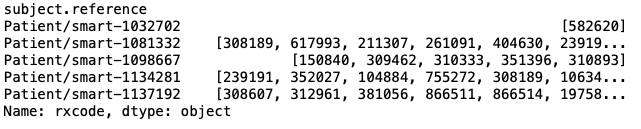

Hint: to accomplish this try modifying the GroupBy function to merge our drugs by patient, and then apply a lambda function, to append the code values to a lst.

In [13]:
groups_by_patient = dffinal.groupby('subject.reference', sort=False)['rxcode'].apply(lambda x: x.values.tolist())
groups_by_patient.head()

subject.reference
Patient/smart-1032702                                             [582620]
Patient/smart-1081332    [308189, 617993, 211307, 261091, 404630, 23919...
Patient/smart-1098667             [150840, 309462, 310333, 351396, 310893]
Patient/smart-1134281    [239191, 352027, 104884, 755272, 308189, 10634...
Patient/smart-1137192    [308607, 312961, 381056, 866511, 866514, 19758...
Name: rxcode, dtype: object

So now we've generated a list of active prescriptions for each patient, we can now append this list to the RXNav query and determine whether each of these patients may have a drug interaction.

## Step 4: Construct a program to loop through our entire cohort and determine the aggregate risk.

Ok so to recap: we now have a list of patients with associated rxcodes in list form, and we know how to query the RXNav API to determine if a drug interaction exists. 

As a last step let's create a series of functions to iterate through our patient list and for each patient return whether or not a Drug on Drug interaction could occur

As a first step, compose a helper function for taking a string of RXCodes (e.g., '123456+654321') submits it to the API, and returns the result as a formatted JSON file. 

Test our original two combinations to ensure that it is effectively outputting the desired responses.

In [16]:
# Function for calling NIH API
def get_api_data(drug_list):
    try:
        url = 'https://rxnav.nlm.nih.gov/REST/interaction/list.json?rxcuis=' + drug_list
        response = (requests.get(url).text)
        response_json = json.loads(response)
        return response_json

    except Exception as e:
        raise e

Now the tricky part!

For this step you'll want to loop through your patients, and for each patient, append each code in their RXCode list to a string separated by a plus sign (i.e., 'drug1+drug2'). 

Test this mechanism to make sure you are creating the proper string for each patient by outputting it directly.

Then modify your for loop to insert that string into the helper function you previously created to return the desired API result. 

Based on the result you can tailor the output to return if an interaction might occur or not. 

While you can choose how you want to format this, here is one possible output format you may want to build towards:

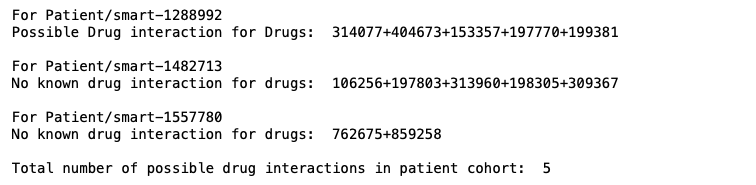

In [22]:
# Declare variables for patient index counting and the sum total of potential drug interactions
count_drug_int = 0
patient_index = 0

In [23]:
# Iterate through each patient list of medications
for drug_list in groups_by_patient:
    print('For',dffinal['subject.reference'][patient_index])
    joined_drug_list = "+".join(str(i) for i in drug_list)
    data = get_api_data(joined_drug_list) # returns JSON response
    if 'fullInteractionTypeGroup' not in data:
        print('No known drug interaction for drugs: ', joined_drug_list,'\n')
        patient_index += len(drug_list)
        continue
    count_drug_int += 1
    patient_index += len(drug_list)
    print('Possible Drug interaction for Drugs: ', joined_drug_list,'\n')
patient_index +=1

print('Total number of possible drug interactions in patient cohort: ', count_drug_int)

For Patient/smart-1032702
No known drug interaction for drugs:  582620 

For Patient/smart-1081332
Possible Drug interaction for Drugs:  308189+617993+211307+261091+404630+239191+208406 

For Patient/smart-1098667
No known drug interaction for drugs:  150840+309462+310333+351396+310893 

For Patient/smart-1134281
Possible Drug interaction for Drugs:  239191+352027+104884+755272+308189+106346+617423 

For Patient/smart-1137192
Possible Drug interaction for Drugs:  308607+312961+381056+866511+866514+197589+762675 

For Patient/smart-1157764
No known drug interaction for drugs:  151124+877300+311992+285128 

For Patient/smart-1186747
Possible Drug interaction for Drugs:  745679+404473+284429+404630+352318+352319+745752 

For Patient/smart-1288992
Possible Drug interaction for Drugs:  314077+404673+153357+197770+199381 

For Patient/smart-1482713
No known drug interaction for drugs:  106256+197803+313960+198305+309367 

For Patient/smart-1557780
No known drug interaction for drugs:  762675

As a bonus consider some additional information you can output, such as keeping a running count of total interactions, or specific details about the interaction types.

## Summary

This exercise demonstrates how FHIR data can interact with the broader ecosystem of healthcare data and resources to determine additional health care insights. Here we pulled data from multiple resources into a unified dataframe, and then modified how the data was stored in order to pass it through to a third-party API and determine health outcomes.